<a href="https://colab.research.google.com/github/ziatdinovmax/APS2020Tutorial/blob/master/APS2020_NNRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression with a neural network in PyTorch

Created: February 2019

Author: Maxim Ziatdinov

Email: ziatdinovmax@gmail.com


---

Neural networks are [universal function approximators](https://en.wikipedia.org/wiki/Universal_approximation_theorem). Here, as a simple illustration, we will generate data points using $e^{0.2x} \times sin(x)$ function, corrupt the produced data by random noise and then will "fit" the target distribution with a neural network. Our regressor will be implemented using [PyTorch](https://pytorch.org/) deep/machine learning framework.

---

Imports:

In [0]:
import torch
import matplotlib.pyplot as plt

Define a helper function that set seeds for generating random numbers (for reproducibility):

In [0]:
def rng_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # for GPU
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

Generate regression set:

In [0]:
rng_seed(1)
x = torch.unsqueeze(torch.arange(-10, 10, 0.01), dim=1)
y = torch.sin(x)*torch.exp(.2*x) + 0.2*torch.randn(x.size())

Plot generated set:

Text(0, 0.5, 'y')

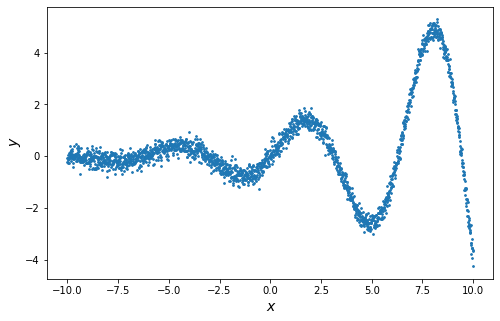

In [0]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(x, y, s=3)
ax.set_xlabel('x', fontsize=14, style='italic')
ax.set_ylabel('y', fontsize=14, style='italic')

We are now going to constuct a simple neural network to fit the data distribution. Our neural network has just two [fully-connected layers](https://en.wikipedia.org/wiki/Multilayer_perceptron), each with 100 neurons, activated by [leaky rectified linear unit function](https://towardsdatascience.com/activation-functions-and-its-types-which-is-better-a9a5310cc8f). We will use Pytorch sequential container to build this simple model (later we will show how to construct a model in the object-oriented way):

Build a model:

In [0]:
rng_seed(1)

model = torch.nn.Sequential(
        torch.nn.Linear(in_features=1, out_features=100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(in_features=100, out_features=100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(in_features=100, out_features=1),
    )

Move our model together with the training data to a GPU device if it is available:

In [0]:
if torch.cuda.is_available():
    model.cuda()
    x = x.cuda()
    y = y.cuda()

Specify parameters for model training, namely weights optimizer and loss function (criterion):

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # Adam optimizer
criterion = torch.nn.MSELoss() # mean-squared loss

Finally, we train our simple model:

(this should take  ~1 minute)

In [0]:
EPOCHS = 2500 # number of training "cycles"

losses = []
for e in range(EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # propagate variable x through a network and get model's prediction
    y_predicted = model(x)
    # compare predicted value with true value and calculate mean squared error
    loss = criterion(y_predicted, y)
    # do backpropagation to compute gradients
    loss.backward()
    # optimize weights
    optimizer.step() 
    # save loss
    losses.append(loss.item())
    # print statistics
    if e % 100 == 0:
        print('Epoch: {}  Loss: {}'.format(e, loss.item()))

Epoch: 0  Loss: 2.6368918418884277
Epoch: 100  Loss: 2.1114261150360107
Epoch: 200  Loss: 1.6979963779449463
Epoch: 300  Loss: 1.5155922174453735
Epoch: 400  Loss: 1.256343126296997
Epoch: 500  Loss: 0.9209522604942322
Epoch: 600  Loss: 0.6067993640899658
Epoch: 700  Loss: 0.38440290093421936
Epoch: 800  Loss: 0.24734370410442352
Epoch: 900  Loss: 0.17142796516418457
Epoch: 1000  Loss: 0.12446464598178864
Epoch: 1100  Loss: 0.09670647978782654
Epoch: 1200  Loss: 0.0800246000289917
Epoch: 1300  Loss: 0.07349202036857605
Epoch: 1400  Loss: 0.06224483624100685
Epoch: 1500  Loss: 0.05762117728590965
Epoch: 1600  Loss: 0.053612176328897476
Epoch: 1700  Loss: 0.05087723955512047
Epoch: 1800  Loss: 0.04890260100364685
Epoch: 1900  Loss: 0.047312602400779724
Epoch: 2000  Loss: 0.04627610743045807
Epoch: 2100  Loss: 0.045338742434978485
Epoch: 2200  Loss: 0.0520283542573452
Epoch: 2300  Loss: 0.04964273422956467
Epoch: 2400  Loss: 0.043663181364536285


Notice that to re-run the model training, you will need to re-initialize your model first ([in this cell](#scrollTo=Td1tsIA8BXP6)).



Plot the training loss history:

Text(0, 0.5, 'Training loss')

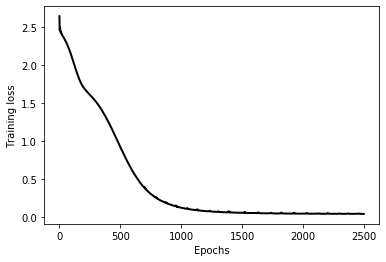

In [0]:
plt.plot(losses, c='black', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Training loss')

Transfer data back to CPU (if we used GPU) and convert it to numpy for plotting:

In [0]:
x_to_plot = x.cpu().numpy()
y_to_plot = y.cpu().numpy()
y_predicted_to_plot = y_predicted.cpu().data.numpy()

Plot results:

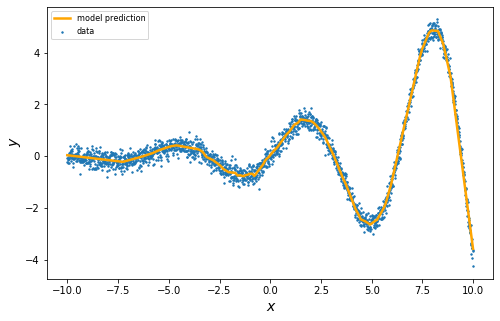

In [0]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(x_to_plot, y_to_plot, s=2, label='data')
ax.plot(x_to_plot, y_predicted_to_plot, c='orange', 
        linewidth=2.5, label='model prediction')
ax.set_xlabel('x', fontsize=14, style='italic')
ax.set_ylabel('y', fontsize=14, style='italic')
ax.legend(loc='best', fontsize=8)

Now let's define the same model in the object-oriented way. While simple networks can be written using the sequential container (as in the example above), more complex networks are typically defined in the object-oriented way. To  do this, first we need to specify model parameters (using ```__init__```) and then outline how they are applied to the inputs (using ```forward```).

In [0]:
class NNRegressor(torch.nn.Module):
    """2-layer neural network for regression"""
    def __init__(self, nb_neurons):
        """Initialization of model parameters"""
        super(NNRegressor, self).__init__()
        self.layer1 = torch.nn.Linear(1, nb_neurons)
        self.layer2 = torch.nn.Linear(nb_neurons, nb_neurons)
        self.output_layer = torch.nn.Linear(nb_neurons, 1)
        self.lrelu = torch.nn.functional.leaky_relu

    def forward(self, x):
        """Forward path"""
        l1 = self.lrelu(self.layer1(x))
        l2 = self.lrelu(self.layer2(l1))
        return self.output_layer(l2)

Next we initalize our model and specify the same training parameters as before:

In [0]:
rng_seed(1)
# Itialize our model
model = NNRegressor(nb_neurons=100)
# Move to GPU (if available)
if torch.cuda.is_available():
    model.cuda()
    x = x.cuda()
    y = y.cuda()
# Specify weights optimizer and loss function (criterion)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # Adam optimizer
criterion = torch.nn.MSELoss() # mean-squared loss

Train a model:

In [0]:
EPOCHS = 2500 # number of training "cycles"

losses = []
for e in range(EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # propagate variable x through a network and get model's prediction
    y_predicted = model(x)
    # compare predicted value with true value and calculate mean squared error
    loss = criterion(y_predicted, y)
    # do backpropagation to compute gradients
    loss.backward()
    # optimize weights
    optimizer.step() 
    # save loss
    losses.append(loss.item())
    # print statistics
    if e % 100 == 0:
        print('Epoch: {}  Loss: {}'.format(e, loss.item()))

Epoch: 0  Loss: 2.6368918418884277
Epoch: 100  Loss: 2.1114261150360107
Epoch: 200  Loss: 1.6979963779449463
Epoch: 300  Loss: 1.5155922174453735
Epoch: 400  Loss: 1.256343126296997
Epoch: 500  Loss: 0.9209522604942322
Epoch: 600  Loss: 0.6067993640899658
Epoch: 700  Loss: 0.38440290093421936
Epoch: 800  Loss: 0.24734370410442352
Epoch: 900  Loss: 0.17142796516418457
Epoch: 1000  Loss: 0.12446464598178864
Epoch: 1100  Loss: 0.09670647978782654
Epoch: 1200  Loss: 0.0800246000289917
Epoch: 1300  Loss: 0.07349202036857605
Epoch: 1400  Loss: 0.06224483624100685
Epoch: 1500  Loss: 0.05762117728590965
Epoch: 1600  Loss: 0.053612176328897476
Epoch: 1700  Loss: 0.05087723955512047
Epoch: 1800  Loss: 0.04890260100364685
Epoch: 1900  Loss: 0.047312602400779724
Epoch: 2000  Loss: 0.04627610743045807
Epoch: 2100  Loss: 0.045338742434978485
Epoch: 2200  Loss: 0.0520283542573452
Epoch: 2300  Loss: 0.04964273422956467
Epoch: 2400  Loss: 0.043663181364536285


To re-train your model, you will need to re-initialize it ([in this cell](#scrollTo=BD8qbG79dNZ6)).

Plot the training loss history:

Text(0, 0.5, 'Training loss')

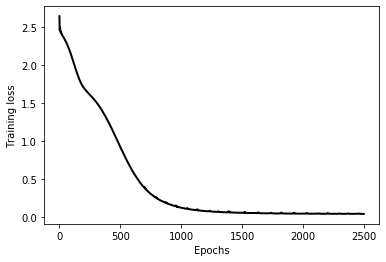

In [0]:
plt.plot(losses, c='black', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Training loss')

Transfer data back to CPU (if we used GPU for training) and convert it to numpy array for plotting:

In [0]:
x_to_plot = x.cpu().numpy()
y_to_plot = y.cpu().numpy()
y_predicted_to_plot = y_predicted.cpu().data.numpy()

Plot results:

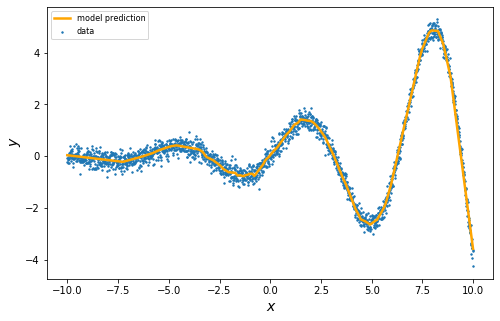

In [0]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(x_to_plot, y_to_plot, s=2, label='data')
ax.plot(x_to_plot, y_predicted_to_plot, c='orange', 
        linewidth=2.5, label='model prediction')
ax.set_xlabel('x', fontsize=14, style='italic')
ax.set_ylabel('y', fontsize=14, style='italic')
ax.legend(loc='best', fontsize=8)

Now let's see how good is our model at making predictions for new data points.

In [0]:
new_data_point = 2.575
print("Is this a new data point?", new_data_point not in x)
new_var = torch.Tensor([[new_data_point]])
print("Trained model predicton:", model(new_var).item())
print("True value:", (torch.sin(new_var)*torch.exp(.2*new_var)).item())

Is this a new data point? True
Trained model predicton: 0.8925276398658752
True value: 0.8983426094055176
